In [2]:
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

In [3]:
con = db.connect("../../ingestao_de_dados/database/db_distribuicao_profissoes.db")

In [ ]:
con.execute("SHOW TABLES").df()

,name
0,tbl_advogados_brasil_2024
1,tbl_contadores_brasil_2024
2,tbl_engenheiros_brasil_2024
3,tbl_estados_brasil
4,tbl_psicologos_brasil_2024


In [ ]:
tabelas = {
    "advogados": "tbl_advogados_brasil_2024",
    "contadores": "tbl_contadores_brasil_2024",
    "engenheiros": "tbl_engenheiros_brasil_2024",
    "psicologos": "tbl_psicologos_brasil_2024",
    "estados": "tbl_estados_brasil"
}

tabela = {nome: con.execute(f"SELECT * FROM {tabela}").df() for nome, tabela in tabelas.items()}

In [6]:
tabela['advogados']

,estado,feminino,masculino
0,AC,1898,2078
1,AL,7376,7847
2,AM,8181,7544
3,AP,2124,2049
4,BA,33281,28654
5,CE,19541,20292
6,DF,26508,25358
7,ES,14451,13009
8,GO,28562,25229
9,MA,12026,12020


In [7]:
tabela['contadores']

,estado,feminino,masculino
0,DF,6407,4512
1,GO,6276,4137
2,MS,2886,2637
3,MT,4241,4037
4,AL,1832,1433
5,BA,9497,7314
6,CE,5587,4375
7,MA,3425,2475
8,PB,2811,2247
9,PE,5904,5094


In [8]:
tabela['engenheiros']

,estado,feminino,masculino
0,CREA-AC,710,1892
1,CREA-AL,1677,7159
2,CREA-AM,4236,11833
3,CREA-AP,391,1278
4,CREA-BA,12202,39436
5,CREA-CE,4673,19166
6,CREA-DF,4602,18081
7,CREA-ES,6004,17778
8,CREA-GO,8487,28991
9,CREA-MA,3821,12044


In [9]:
tabela['psicologos']

,estado,feminino,masculino
0,Acre,1181,236
1,Alagoas,5399,991
2,Amapá,1201,261
3,Amazonas,5163,996
4,Bahia,21113,3559
5,Ceará,12387,2508
6,Distrito Federal,13246,2407
7,Espírito Santo,7601,1499
8,Goiás,13638,1966
9,Maranhão,5475,1028


In [10]:
tabela['estados']

,id,uf,nome_estado
0,1,AC,Acre
1,2,AL,Alagoas
2,4,AM,Amazonas
3,5,AP,Amapá
4,6,BA,Bahia
5,7,CE,Ceará
6,8,DF,Distrito Federal
7,9,ES,Espírito Santo
8,10,GO,Goiás
9,11,MA,Maranhão


In [ ]:
con.execute("DESCRIBE tbl_advogados_brasil_2024").df()
con.execute("DESCRIBE tbl_contadores_brasil_2024").df()
con.execute("DESCRIBE tbl_engenheiros_brasil_2024").df()
con.execute("DESCRIBE tbl_psicologos_brasil_2024").df()

,column_name,column_type,null,key,default,extra
0,estado,VARCHAR,NO,PRI,None,None
1,feminino,INTEGER,YES,None,None,None
2,masculino,INTEGER,YES,None,None,None


In [12]:
query = """
    SELECT *, 'advogado' AS profissao
    FROM tbl_advogados_brasil_2024

    UNION ALL

    SELECT *, 'contador' AS profissao
    FROM tbl_contadores_brasil_2024

    UNION ALL

    SELECT *, 'engenheiro' AS profissao
    FROM tbl_engenheiros_brasil_2024

    UNION ALL

    SELECT *, 'psicologo' AS profissao
    FROM tbl_psicologos_brasil_2024
"""

In [ ]:
df_profissoes = con.execute(query).df()
df_profissoes

,estado,feminino,masculino,profissao
0,AC,1898,2078,advogado
1,AL,7376,7847,advogado
2,AM,8181,7544,advogado
3,AP,2124,2049,advogado
4,BA,33281,28654,advogado
...,...,...,...,...
103,Roraima,971,167,psicologo
104,Santa Catarina,17963,2739,psicologo
105,São Paulo,132077,22613,psicologo
106,Sergipe,3372,723,psicologo


In [14]:
df_profissoes[df_profissoes['profissao'] == 'advogado'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,27508.518519,25522.851852
std,39997.618600,36525.059606
min,1473.000000,1398.000000
25%,7741.000000,7695.500000
50%,13516.000000,12059.000000
75%,27792.500000,25293.500000
max,197236.000000,181116.000000


In [15]:
df_profissoes[df_profissoes['profissao'] == 'contador'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,7631.000000,6777.518519
std,11128.348709,9851.721413
min,501.000000,512.000000
25%,2207.000000,1976.000000
50%,4174.000000,4037.000000
75%,7952.000000,6521.000000
max,56528.000000,49302.000000


In [16]:
df_profissoes[df_profissoes['profissao'] == 'engenheiro'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,8695.222222,34465.666667
std,11525.265271,56973.482517
min,391.000000,1119.000000
25%,2029.000000,7572.000000
50%,4602.000000,17778.000000
75%,10007.500000,33231.500000
max,53124.000000,281812.000000


In [17]:
df_profissoes[df_profissoes['profissao'] == 'psicologo'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,16698.592593,2884.222222
std,26513.606301,4540.061041
min,971.000000,167.000000
25%,4584.000000,756.000000
50%,6371.000000,1206.000000
75%,17526.500000,2834.500000
max,132077.000000,22613.000000


In [18]:
# con.close()

In [19]:
df_estados_profissoes = con.execute("""
    SELECT
        a.id,
        a.nome_estado,
        b.M_advogados,
        b.F_advogados,
        c.M_contadores,
        c.F_contadores,
        d.M_engenheiros,
        d.F_engenheiros,
        e.M_psicologos,
        e.F_psicologos
    
    FROM tbl_estados_brasil AS a 
    
    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_advogados,
            feminino AS F_advogados
        FROM tbl_advogados_brasil_2024        
    ) AS b ON UPPER(a.uf) = b.estado

    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_contadores,
            feminino AS F_contadores
        FROM tbl_contadores_brasil_2024
    ) AS c ON UPPER(a.uf) = c.estado

    LEFT JOIN(
        SELECT 
            UPPER(REPLACE(estado, 'CREA-', '')) AS estado,
            masculino AS M_engenheiros,
            feminino AS F_engenheiros
        FROM tbl_engenheiros_brasil_2024
    ) AS d ON UPPER(a.uf) = d.estado

    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_psicologos,
            feminino AS F_psicologos
        FROM tbl_psicologos_brasil_2024
    ) AS e ON UPPER(a.nome_estado) = e.estado
""").df()

In [20]:
df_estados_profissoes

,id,nome_estado,M_advogados,F_advogados,M_contadores,F_contadores,M_engenheiros,F_engenheiros,M_psicologos,F_psicologos
0,1,Acre,2078,1898,512,539,1892,710,236,1181
1,2,Alagoas,7847,7376,1433,1832,7159,1677,991,5399
2,4,Amazonas,7544,8181,3106,2532,11833,4236,996,5163
3,5,Amapá,2049,2124,660,743,1278,391,261,1201
4,6,Bahia,28654,33281,7314,9497,39436,12202,3559,21113
5,7,Ceará,20292,19541,4375,5587,19166,4673,2508,12387
6,8,Distrito Federal,25358,26508,4512,6407,18081,4602,2407,13246
7,9,Espírito Santo,13009,14451,4174,4174,17778,6004,1499,7601
8,10,Goiás,25229,28562,4137,6276,28991,8487,1966,13638
9,11,Maranhão,12020,12026,2475,3425,12044,3821,1028,5475


In [24]:
df_totais = con.execute("""
SELECT 'Advogados' AS profissao, SUM(M_advogados) + SUM(F_advogados) AS total FROM df_estados_profissoes
UNION ALL
SELECT 'Contadores', SUM(M_contadores) + SUM(F_contadores) FROM df_estados_profissoes
UNION ALL
SELECT 'Engenheiros', SUM(M_engenheiros) + SUM(F_engenheiros) FROM df_estados_profissoes
UNION ALL
SELECT 'Psicólogos', SUM(M_psicologos) + SUM(F_psicologos) FROM df_estados_profissoes
""").df()
df_totais

,profissao,total
0,Advogados,1431847.0
1,Contadores,389030.0
2,Engenheiros,1165344.0
3,Psicólogos,528736.0


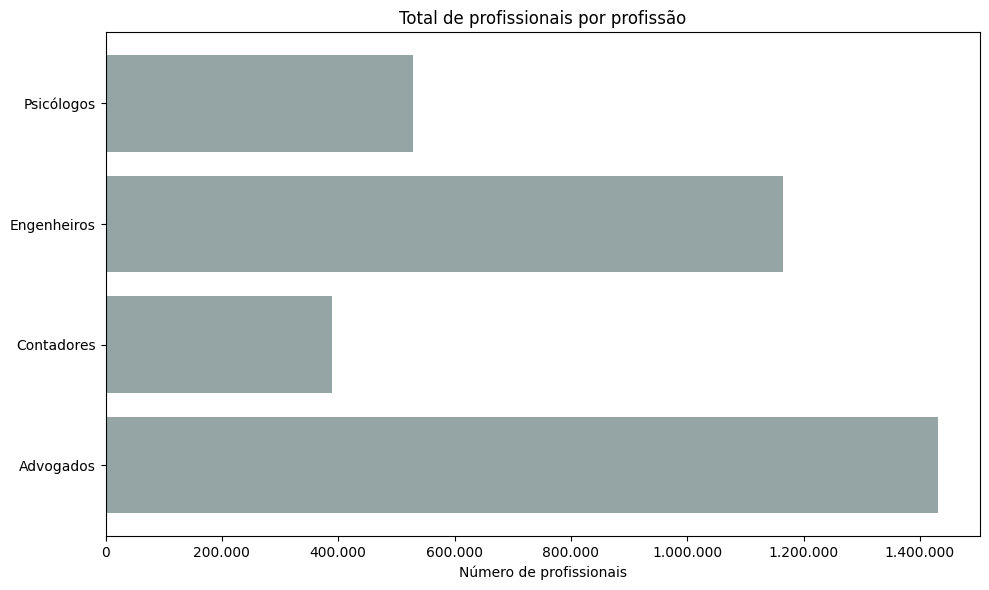

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df_totais['profissao'], df_totais['total'], color='#95a5a6')
ax.set_title('Total de profissionais por profissão')
ax.set_xlabel('Número de profissionais')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
plt.tight_layout()
plt.show()

In [28]:
top5_advogados = con.execute("""
    SELECT nome_estado, (M_advogados + F_advogados) AS total_advogados
    FROM df_estados_profissoes
    ORDER BY total_advogados DESC
    LIMIT 5
""").df()

top5_contadores = con.execute("""
    SELECT nome_estado, (M_contadores + F_contadores) AS total_contadores
    FROM df_estados_profissoes
    ORDER BY total_contadores DESC
    LIMIT 5
""").df()

top5_engenheiros = con.execute("""
    SELECT nome_estado, (M_engenheiros + F_engenheiros) AS total_engenheiros
    FROM df_estados_profissoes
    ORDER BY total_engenheiros DESC
    LIMIT 5
""").df()

top5_psicologos = con.execute("""
    SELECT nome_estado, (M_psicologos + F_psicologos) AS total_psicologos
    FROM df_estados_profissoes
    ORDER BY total_psicologos DESC
    LIMIT 5
""").df()

In [29]:
display(top5_advogados)
display(top5_contadores)
display(top5_engenheiros)
display(top5_psicologos)

,nome_estado,total_advogados
0,São Paulo,378352
1,Rio de Janeiro,159025
2,Minas Gerais,144147
3,Rio Grande do Sul,98688
4,Paraná,91891


,nome_estado,total_contadores
0,São Paulo,105830
1,Rio de Janeiro,38143
2,Minas Gerais,36471
3,Paraná,27960
4,Rio Grande do Sul,25996


,nome_estado,total_engenheiros
0,São Paulo,334936
1,Minas Gerais,154335
2,Rio de Janeiro,117187
3,Paraná,71868
4,Rio Grande do Sul,68162


,nome_estado,total_psicologos
0,São Paulo,154690
1,Rio de Janeiro,59158
2,Minas Gerais,57498
3,Paraná,31757
4,Rio Grande do Sul,31681


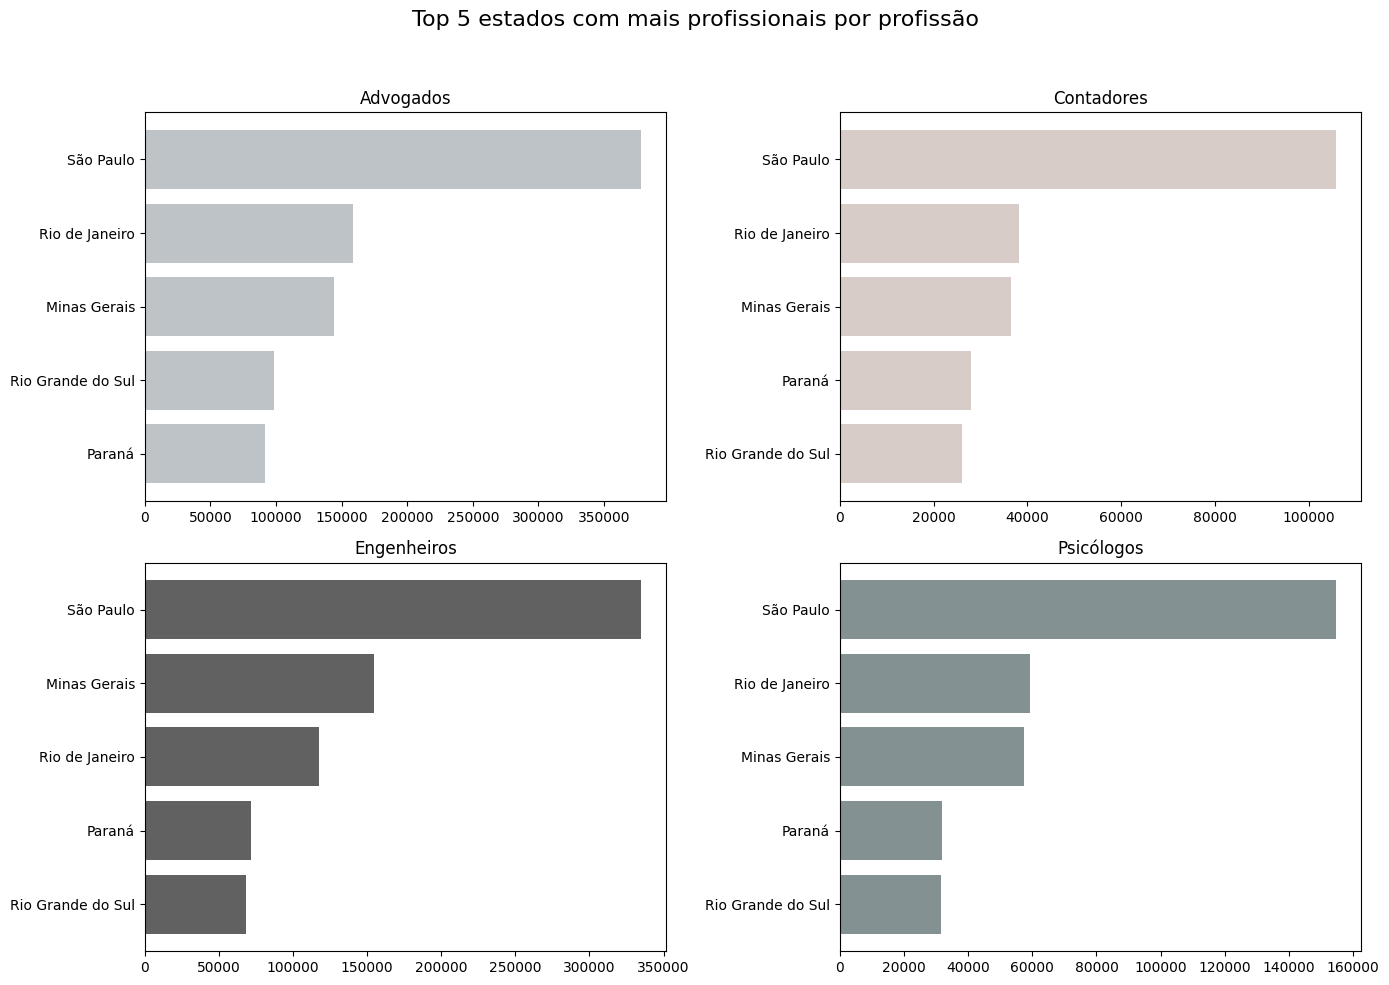

In [30]:
# Soma homens e mulheres de cada profissão
# Cria os subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Top 5 estados com mais profissionais por profissão', fontsize=16)

# Gráfico 1: Advogados
axs[0, 0].barh(top5_advogados['nome_estado'], top5_advogados['total_advogados'], color='#bdc3c7')
axs[0, 0].set_title('Advogados')
axs[0, 0].invert_yaxis()

# Gráfico 2: Contadores
axs[0, 1].barh(top5_contadores['nome_estado'], top5_contadores['total_contadores'], color='#d7ccc8')
axs[0, 1].set_title('Contadores')
axs[0, 1].invert_yaxis()

# Gráfico 3: Engenheiros
axs[1, 0].barh(top5_engenheiros['nome_estado'], top5_engenheiros['total_engenheiros'], color='#616161')
axs[1, 0].set_title('Engenheiros')
axs[1, 0].invert_yaxis()

# Gráfico 4: Psicólogos
axs[1, 1].barh(top5_psicologos['nome_estado'], top5_psicologos['total_psicologos'], color='#839192')
axs[1, 1].set_title('Psicólogos')
axs[1, 1].invert_yaxis()

# Ajusta layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [31]:
genero_totais = con.execute("""
    SELECT 
        SUM(M_advogados)   AS homens_advogados,
        SUM(F_advogados)   AS mulheres_advogados,
        SUM(M_contadores)  AS homens_contadores,
        SUM(F_contadores)  AS mulheres_contadores,
        SUM(M_engenheiros) AS homens_engenheiros,
        SUM(F_engenheiros) AS mulheres_engenheiros,
        SUM(M_psicologos)  AS homens_psicologos,
        SUM(F_psicologos)  AS mulheres_psicologos
    FROM df_estados_profissoes
""").df()

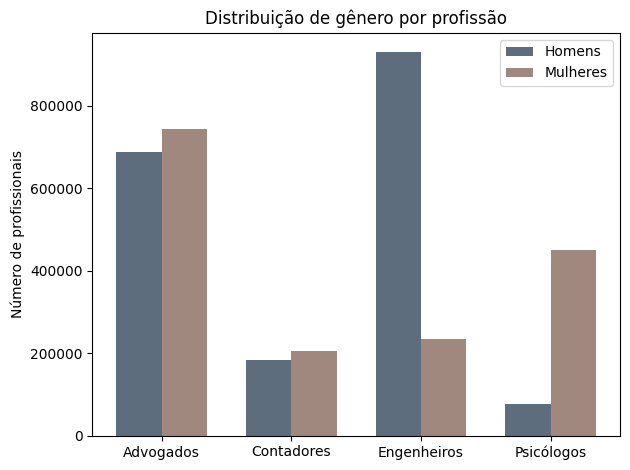

In [32]:
profissoes = ['Advogados', 'Contadores', 'Engenheiros', 'Psicólogos']

genero_m = [
    df_estados_profissoes['M_advogados'].sum(),
    df_estados_profissoes['M_contadores'].sum(),
    df_estados_profissoes['M_engenheiros'].sum(),
    df_estados_profissoes['M_psicologos'].sum(),
]

genero_f = [
    df_estados_profissoes['F_advogados'].sum(),
    df_estados_profissoes['F_contadores'].sum(),
    df_estados_profissoes['F_engenheiros'].sum(),
    df_estados_profissoes['F_psicologos'].sum(),
]

x = np.arange(len(profissoes))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, genero_m, width, label='Homens', color='#5d6d7e')
ax.bar(x + width/2, genero_f, width, label='Mulheres', color='#a1887f')

ax.set_ylabel('Número de profissionais')
ax.set_title('Distribuição de gênero por profissão')
ax.set_xticks(x)
ax.set_xticklabels(profissoes)
ax.legend()
plt.tight_layout()
plt.show()

In [33]:
con.close()